In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import numpy as np 
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
import umap
import matplotlib
%matplotlib inline
import pickle
import sklearn
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# import sentence_transformers
plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
gene_info_table = pd.read_csv('input_data/gene_info_table.csv')

In [4]:
from src.utils import setup_data_dir

setup_data_dir()

File already exists at /Users/rj/personal/GenePT/data/GenePT_emebdding_v2.zip
Extracting files...
Extracting GenePT_emebdding_v2/
Skipping GenePT_emebdding_v2/NCBI_UniProt_summary_of_genes.json - already exists with same size
Skipping GenePT_emebdding_v2/GenePT_gene_embedding_ada_text.pickle - already exists with same size
Skipping GenePT_emebdding_v2/GenePT_gene_protein_embedding_model_3_text.pickle. - already exists with same size
Skipping GenePT_emebdding_v2/NCBI_summary_of_genes.json - already exists with same size
Extraction complete!
Setup finished!


In [5]:
from src.utils import get_gene_embeddings
# gene_embedding = get_gene_embeddings("text-embedding-ada-002")
gene_embedding = get_gene_embeddings("text-embedding-3-large")

In [6]:
# Create random embeddings as negative controls
np.random.seed(2023)
N_DIM = 1536
fake_pretrain_embed = dict()
for key in gene_embedding.keys():
    fake_pretrain_embed[key] = np.random.normal(size=(N_DIM))

In [7]:
# Create a new column "gpt_embed" with default value as False
gene_info_table['gpt_embed'] = False

# Update the new column based on the condition
def check_embedding(row):
    gene = row['gene_name']
    if gene in gene_embedding:
        embed_value = gene_embedding[gene]
        if np.any(embed_value != 0):
            return True
    return False

gene_info_table['gpt_embed'] = gene_info_table.apply(check_embedding, axis=1)
# Create a subset where gpt_embed is True
subset = gene_info_table[gene_info_table['gpt_embed']]

# Find gene_type elements with occurrences > 50 (in this case, just for demonstration, I'll use > 2)
gene_type_counts = subset['gene_type'].value_counts()
common_gene_types = gene_type_counts[gene_type_counts > 75].index

# Create a final subset of the original DataFrame with only these gene_type elements
final_subset = gene_info_table[(gene_info_table['gene_type'].isin(common_gene_types))\
                               &(gene_info_table['gpt_embed'])]

# let's do a very simple classification for final_subset
X_list = []
y_list = []
# Iterate through rows of final_subset
for index, row in final_subset.iterrows():
    gene_name = row['gene_name']
    gene_type = row['gene_type']
    # Add the embedding from the dictionary to the x list
    if gene_name in gene_embedding:
        X_list.append(gene_embedding[gene_name])
    
    # Add the gene_type to the y list
        y_list.append(gene_type)

In [8]:
np.random.seed(2023)
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_list, y_list, test_size=0.30, random_state=2023)

# Verify the split
print(f"Training set size (X_train): {len(X_train)}")
print(f"Test set size (X_test): {len(X_test)}")
# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

Training set size (X_train): 23973
Test set size (X_test): 10275


In [9]:
sklearn.metrics.accuracy_score(y_pred_lr,y_test)

0.9532846715328467

In [10]:
# get expression 
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_normalized_confusion_matrix(y_true, y_pred, classes):
    """
    Plot a normalized confusion matrix using seaborn.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize by row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # replace nan with 0
    cm_normalized = cm_normalized * 100  # convert to percentage
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.0f', annot_kws={'fontsize': 13.5},
                cmap='Blues', xticklabels=classes, yticklabels=classes,cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [11]:
y_pred_lr

array(['protein_coding', 'pseudogene', 'pseudogene', ..., 'snRNA',
       'misc_RNA', 'protein_coding'], shape=(10275,), dtype='<U20')

<Figure size 600x600 with 0 Axes>

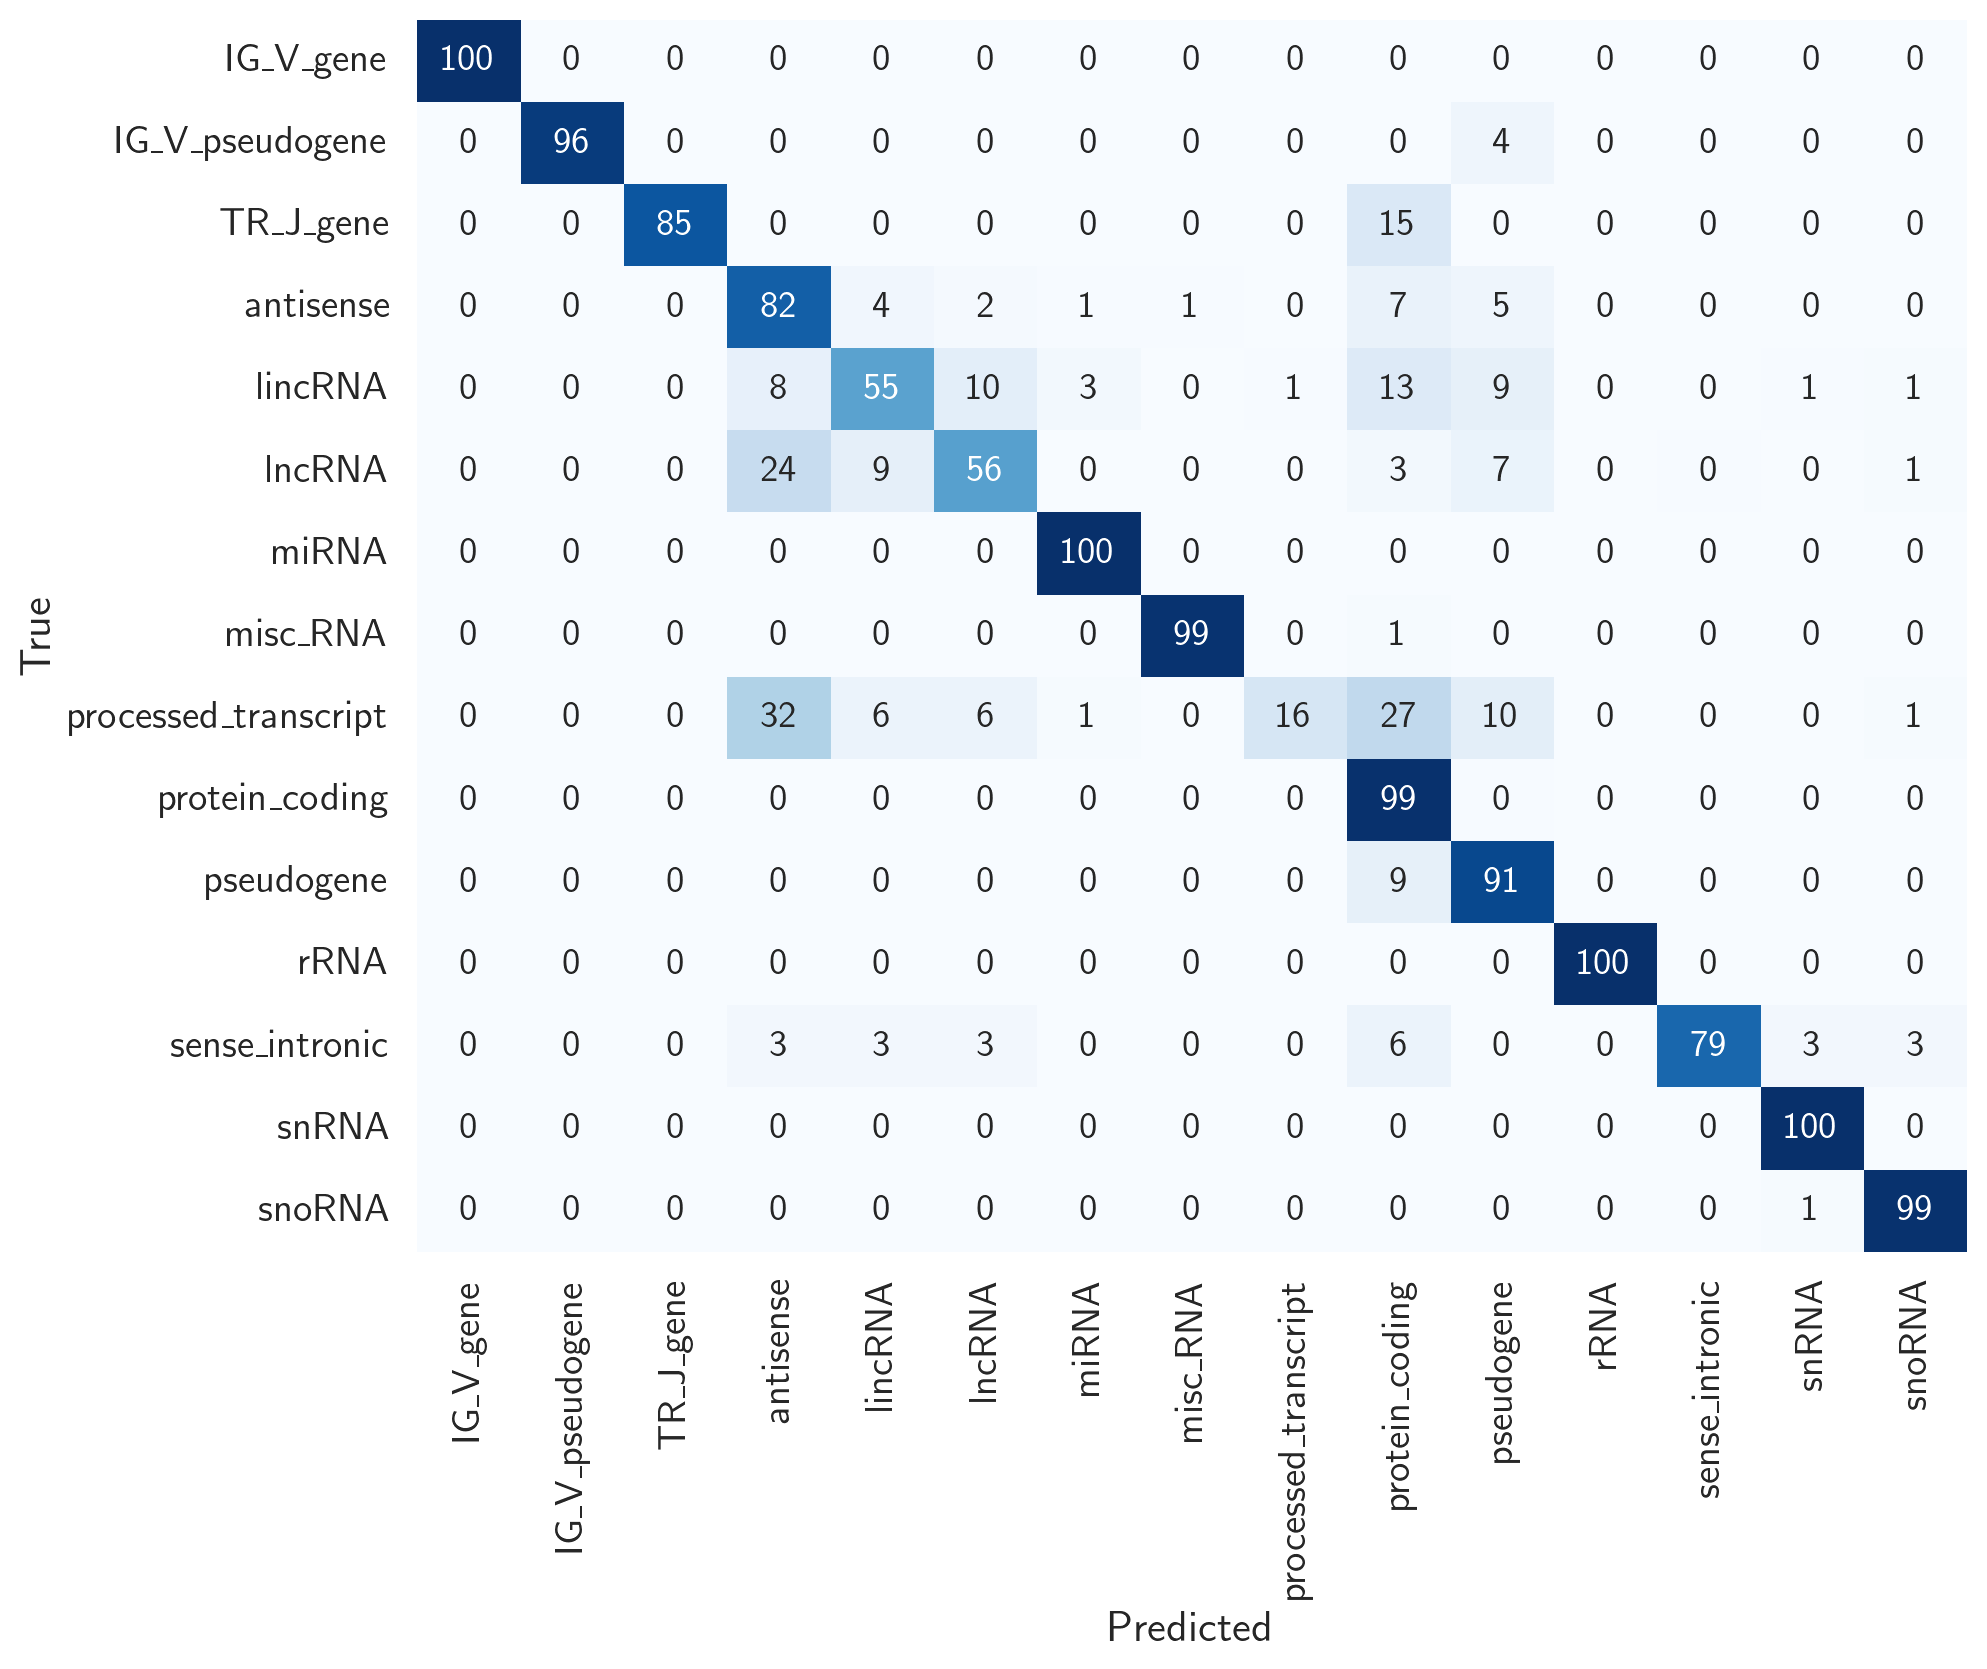

In [12]:
plt.figure(figsize=(6,6))
sns.set(font_scale=1.3)
plot_normalized_confusion_matrix(np.array(y_test),y_pred_lr,np.unique(y_list))

## Gene-gene interaction prediction
#### We showcase the gene-gene interaction prediction use case below. The input data can be downloaded from https://github.com/jingcheng-du/Gene2vec repo.

In [13]:
from src.utils import download_file

train_text_GGI_path = download_file("https://github.com/jingcheng-du/Gene2vec/raw/refs/heads/master/predictionData/train_text.txt", "data/Gene2vec/predictionData/train_text.txt")
train_label_GGI_path = download_file("https://github.com/jingcheng-du/Gene2vec/raw/refs/heads/master/predictionData/train_label.txt", "data/Gene2vec/predictionData/train_label.txt")

# gene gene interaction 
train_text_GGI = pd.read_csv(train_text_GGI_path, sep=' ', header=None)
train_label_GGI = pd.read_csv(train_label_GGI_path, header=None)
train_text_GGI.columns = ['gene_1','gene_2']
train_label_GGI.columns = ['label']
train_text_GGI_df = pd.concat([train_text_GGI,train_label_GGI], axis=1)

File already exists at data/Gene2vec/predictionData/train_text.txt
File already exists at data/Gene2vec/predictionData/train_label.txt


In [14]:
test_text_GGI_path = download_file("https://github.com/jingcheng-du/Gene2vec/raw/refs/heads/master/predictionData/test_text.txt", "data/Gene2vec/predictionData/test_text.txt")
test_label_GGI_path = download_file("https://github.com/jingcheng-du/Gene2vec/raw/refs/heads/master/predictionData/test_label.txt", "data/Gene2vec/predictionData/test_label.txt")

#gene gene interaction
test_text_GGI = pd.read_csv(test_text_GGI_path, sep=' ', header=None)
test_label_GGI = pd.read_csv(test_label_GGI_path, header=None)
test_text_GGI.columns = ['gene_1','gene_2']
test_label_GGI.columns = ['label']
test_text_GGI_df = pd.concat([test_text_GGI,test_label_GGI], axis=1)

File already exists at data/Gene2vec/predictionData/test_text.txt
File already exists at data/Gene2vec/predictionData/test_label.txt


### We choose a simple featurization scheme by *adding* the emebdding vectors of the two genes together:

In [15]:
# try the drug one...
# how do we featurize 
# simplest way is to just take the union of the two input features
X_array_train_random = []
y_array_train_random = []
for i, row in train_text_GGI_df.iterrows():
    if row['gene_1'] in  fake_pretrain_embed \
        and row['gene_2'] in fake_pretrain_embed:
#         X_array_train_random.append([fake_pretrain_embed[row['gene_1']],\
#                              fake_pretrain_embed[row['gene_2']]])
        X_array_train_random.append(fake_pretrain_embed[row['gene_1']]+
                             fake_pretrain_embed[row['gene_2']])
        y_array_train_random.append(row['label'])
X_array_train_random = np.array(X_array_train_random)
y_array_train_random = np.array(y_array_train_random)
X_array_train_random = X_array_train_random.reshape(X_array_train_random.shape[0],-1)

# how do we featurize 
# simplest way is to just take the union of the two input features
X_array_test_random = []
y_array_test_random = []
for i, row in test_text_GGI_df.iterrows():
    if row['gene_1'] in  fake_pretrain_embed \
        and row['gene_2'] in fake_pretrain_embed:
        X_array_test_random.append(fake_pretrain_embed[row['gene_1']]+
                             fake_pretrain_embed[row['gene_2']])
        y_array_test_random.append(row['label'])
X_array_test_random = np.array(X_array_test_random)
y_array_test_random = np.array(y_array_test_random)
X_array_test_random = X_array_test_random.reshape(X_array_test_random.shape[0],-1)

In [16]:

# Using Random Forest for random data
rf_random = LogisticRegression()  # You can add hyperparameters like n_estimators if needed
rf_random.fit(X_array_train_random, y_array_train_random)
y_pred_rf_random = rf_random.predict_proba(X_array_test_random)
fpr_random_rf, tpr_random_rf, _ = sklearn.metrics.roc_curve(y_array_test_random, y_pred_rf_random[:, 1])
auc_rf_random = sklearn.metrics.roc_auc_score(y_array_test_random, y_pred_rf_random[:,1])

del rf_random
del X_array_train_random
del y_array_train_random
del X_array_test_random
del y_array_test_random
del y_pred_rf_random

In [17]:

gene2vec_dim_200_iter_9_path = download_file("https://github.com/jingcheng-du/Gene2vec/raw/refs/heads/master/pre_trained_emb/gene2vec_dim_200_iter_9.txt", "data/Gene2vec/pre_trained_emb/gene2vec_dim_200_iter_9.txt")
gene2vec_dim_200_iter_9 = pd.read_csv(gene2vec_dim_200_iter_9_path, header=None, sep='\t')
pretrain_embed = {}  # Dictionary to hold gene_name: 200-dimensional vector

for index, row in gene2vec_dim_200_iter_9.iterrows():
    gene_name = row[0]
    vector_str = row[1]
    vector = [float(x) for x in vector_str.split()]  
    # Split the string into list of strings, then convert to floats
    if len(vector) == 200:  # Ensure the row has exactly 200 numbers
        pretrain_embed[gene_name] = np.array(vector)

File already exists at data/Gene2vec/pre_trained_emb/gene2vec_dim_200_iter_9.txt


In [18]:
# try the drug one...
# how do we featurize 
# simplest way is to just take the union of the two input features
X_array_train_gene2vec = []
y_array_train_gene2vec = []
for i, row in train_text_GGI_df.iterrows():
    if row['gene_1'] in  pretrain_embed \
        and row['gene_2'] in pretrain_embed:
        X_array_train_gene2vec.append(pretrain_embed[row['gene_1']]+
                             pretrain_embed[row['gene_2']])
        y_array_train_gene2vec.append(row['label'])
X_array_train_gene2vec = np.array(X_array_train_gene2vec)
y_array_train_gene2vec = np.array(y_array_train_gene2vec)
X_array_train_gene2vec = X_array_train_gene2vec.reshape(X_array_train_gene2vec.shape[0],-1)


X_array_test_gene2vec = []
y_array_test_gene2vec = []
for i, row in test_text_GGI_df.iterrows():
    if row['gene_1'] in  pretrain_embed \
        and row['gene_2'] in pretrain_embed:
        X_array_test_gene2vec.append(pretrain_embed[row['gene_1']]+
                             pretrain_embed[row['gene_2']])
        y_array_test_gene2vec.append(row['label'])
X_array_test_gene2vec = np.array(X_array_test_gene2vec)
y_array_test_gene2vec = np.array(y_array_test_gene2vec)
X_array_test_gene2vec = X_array_test_gene2vec.reshape(X_array_test_gene2vec.shape[0],-1)

In [19]:
# Using Random Forest for gene2vec data
rf_gene2vec = LogisticRegression()  # You can add hyperparameters like n_estimators if needed
rf_gene2vec.fit(X_array_train_gene2vec, y_array_train_gene2vec)
y_pred_rf_gene2vec = rf_gene2vec.predict_proba(X_array_test_gene2vec)
fpr_gene2vec_rf, tpr_gene2vec_rf, _ = sklearn.metrics.roc_curve(y_array_test_gene2vec, y_pred_rf_gene2vec[:, 1])
auc_rf_gene2vec = sklearn.metrics.roc_auc_score(y_array_test_gene2vec, y_pred_rf_gene2vec[:,1])

del rf_gene2vec
del X_array_train_gene2vec
del y_array_train_gene2vec
del X_array_test_gene2vec
del y_array_test_gene2vec
del y_pred_rf_gene2vec

#### Replace the LogisticRegression() to RandomForestClassifier to replace the results in the paper (slightly better AUC for GenePT and Gene2vec embeddings); we used the much faster LogisticRegression for illustration purposes here.  

In [29]:
X_array_train = []
y_array_train = []
for i, row in train_text_GGI_df.iterrows():
    if row['gene_1'] in  gene_embedding \
        and row['gene_2'] in gene_embedding:
        X_array_train.append(gene_embedding[row['gene_1']]+\
                             gene_embedding[row['gene_2']])
        y_array_train.append(row['label'])
X_array_train = np.array(X_array_train)
y_array_train = np.array(y_array_train)
X_array_train = X_array_train.reshape(X_array_train.shape[0],-1)

X_array_test = []
y_array_test = []
for i, row in test_text_GGI_df.iterrows():
    if row['gene_1'] in  gene_embedding \
        and row['gene_2'] in gene_embedding:
        X_array_test.append(gene_embedding[row['gene_1']]+\
                             gene_embedding[row['gene_2']])
        y_array_test.append(row['label'])
X_array_test = np.array(X_array_test)
y_array_test = np.array(y_array_test)
X_array_test = X_array_test.reshape(X_array_test.shape[0],-1)

In [21]:


# Using Random Forest for the GenePT data
rf = LogisticRegression()  # You can add hyperparameters like n_estimators if needed
rf.fit(X_array_train, y_array_train)
y_pred_rf = rf.predict_proba(X_array_test)
fpr_rf, tpr_rf, _ = sklearn.metrics.roc_curve(y_array_test, y_pred_rf[:, 1])
rf_auc = sklearn.metrics.roc_auc_score(y_array_test, y_pred_rf[:,1])

del rf
del y_pred_rf

In [22]:
%pip install lightgbm hyperopt==0.2.7 setuptools


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
# import numpy as np
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score
# from lightgbm import LGBMClassifier

# # Sample data for hyperparameter optimization
# n_total_sample = 6000  # 5K for training + 1K for testing
# random_state = 42

# # Modified sampling method
# np.random.seed(random_state)
# sample_indices = np.random.permutation(len(X_array_train))[:n_total_sample]

# # Split the sampled data into train and test sets
# X_sample = X_array_train[sample_indices]
# y_sample = y_array_train[sample_indices]
# X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
#     X_sample, 
#     y_sample, 
#     test_size=1000,  # 1K for validation
#     random_state=random_state
# )

# # Define the parameter space
# space = {
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
#     'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#     'max_depth': hp.quniform('max_depth', 3, 12, 1),
#     'num_leaves': hp.quniform('num_leaves', 8, 128, 4),
#     'min_child_samples': hp.quniform('min_child_samples', 10, 100, 5),
#     'subsample': hp.uniform('subsample', 0.5, 1.0),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
# }

# def objective(params):
#     params = {
#         'learning_rate': float(params['learning_rate']),
#         'n_estimators': int(params['n_estimators']),
#         'max_depth': int(params['max_depth']),
#         'num_leaves': int(params['num_leaves']),
#         'min_child_samples': int(params['min_child_samples']),
#         'subsample': float(params['subsample']),
#         'colsample_bytree': float(params['colsample_bytree']),
#         'objective': 'multiclass',
#         'num_class': len(np.unique(y_array_train)),
#         'random_state': random_state
#     }
    
#     model = LGBMClassifier(**params)
#     model.fit(X_sample_train, y_sample_train)
    
#     y_pred = model.predict(X_sample_val)
#     f1 = f1_score(y_sample_val, y_pred, average='macro')
    
#     return {'loss': -f1, 'status': STATUS_OK}

# # Run hyperparameter optimization with seed
# seed = np.random.randint(2**32)
# trials = Trials()
# best = fmin(
#     fn=objective,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=trials,
# )

# # Get the best parameters
# best_lgbm_params = {
#     'learning_rate': float(best['learning_rate']),
#     'n_estimators': int(best['n_estimators']),
#     'max_depth': int(best['max_depth']),
#     'num_leaves': int(best['num_leaves']),
#     'min_child_samples': int(best['min_child_samples']),
#     'subsample': float(best['subsample']),
#     'colsample_bytree': float(best['colsample_bytree']),
#     'objective': 'multiclass',
#     'num_class': len(np.unique(y_array_train)),
#     'random_state': random_state
# }


In [24]:
import json

# print(json.dumps(best_lgbm_params, indent=2))

In [25]:
best_lgbm_params = {
  "learning_rate": 0.22713273828048675,
  "n_estimators": 210,
  "max_depth": 10,
  "num_leaves": 36,
  "min_child_samples": 25,
  "subsample": 0.9437346898927265,
  "colsample_bytree": 0.5878904780251836,
  "objective": "multiclass",
  "num_class": 2,
  "random_state": 42
}

In [27]:
from lightgbm import LGBMClassifier

# Train final model with best parameters on full training data
lgbm_model = LGBMClassifier(**best_lgbm_params)
lgbm_model.fit(X_array_train, y_array_train)

# Get predictions
y_pred_lgbm = lgbm_model.predict_proba(X_array_test)

fpr_lgbm, tpr_lgbm, _ = sklearn.metrics.roc_curve(y_array_test, y_pred_lgbm[:,1])
auc_lgbm = sklearn.metrics.roc_auc_score(y_array_test, y_pred_lgbm[:,1])

f1_lgbm = sklearn.metrics.f1_score(y_array_test, y_pred_lgbm[:,1] > 0.07)
# 0.07 is just determined empirically

print("F1 score on sample:", f1_lgbm)

/Users/rj/personal/GenePT/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.435522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1566720
[LightGBM] [Info] Number of data points in the train set: 258755, number of used features: 6144
[LightGBM] [Info] Start training from score -0.693909
[LightGBM] [Info] Start training from score -0.692386


/Users/rj/personal/GenePT/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


F1 score on sample: 0.753061396841483


<Figure size 640x480 with 0 Axes>

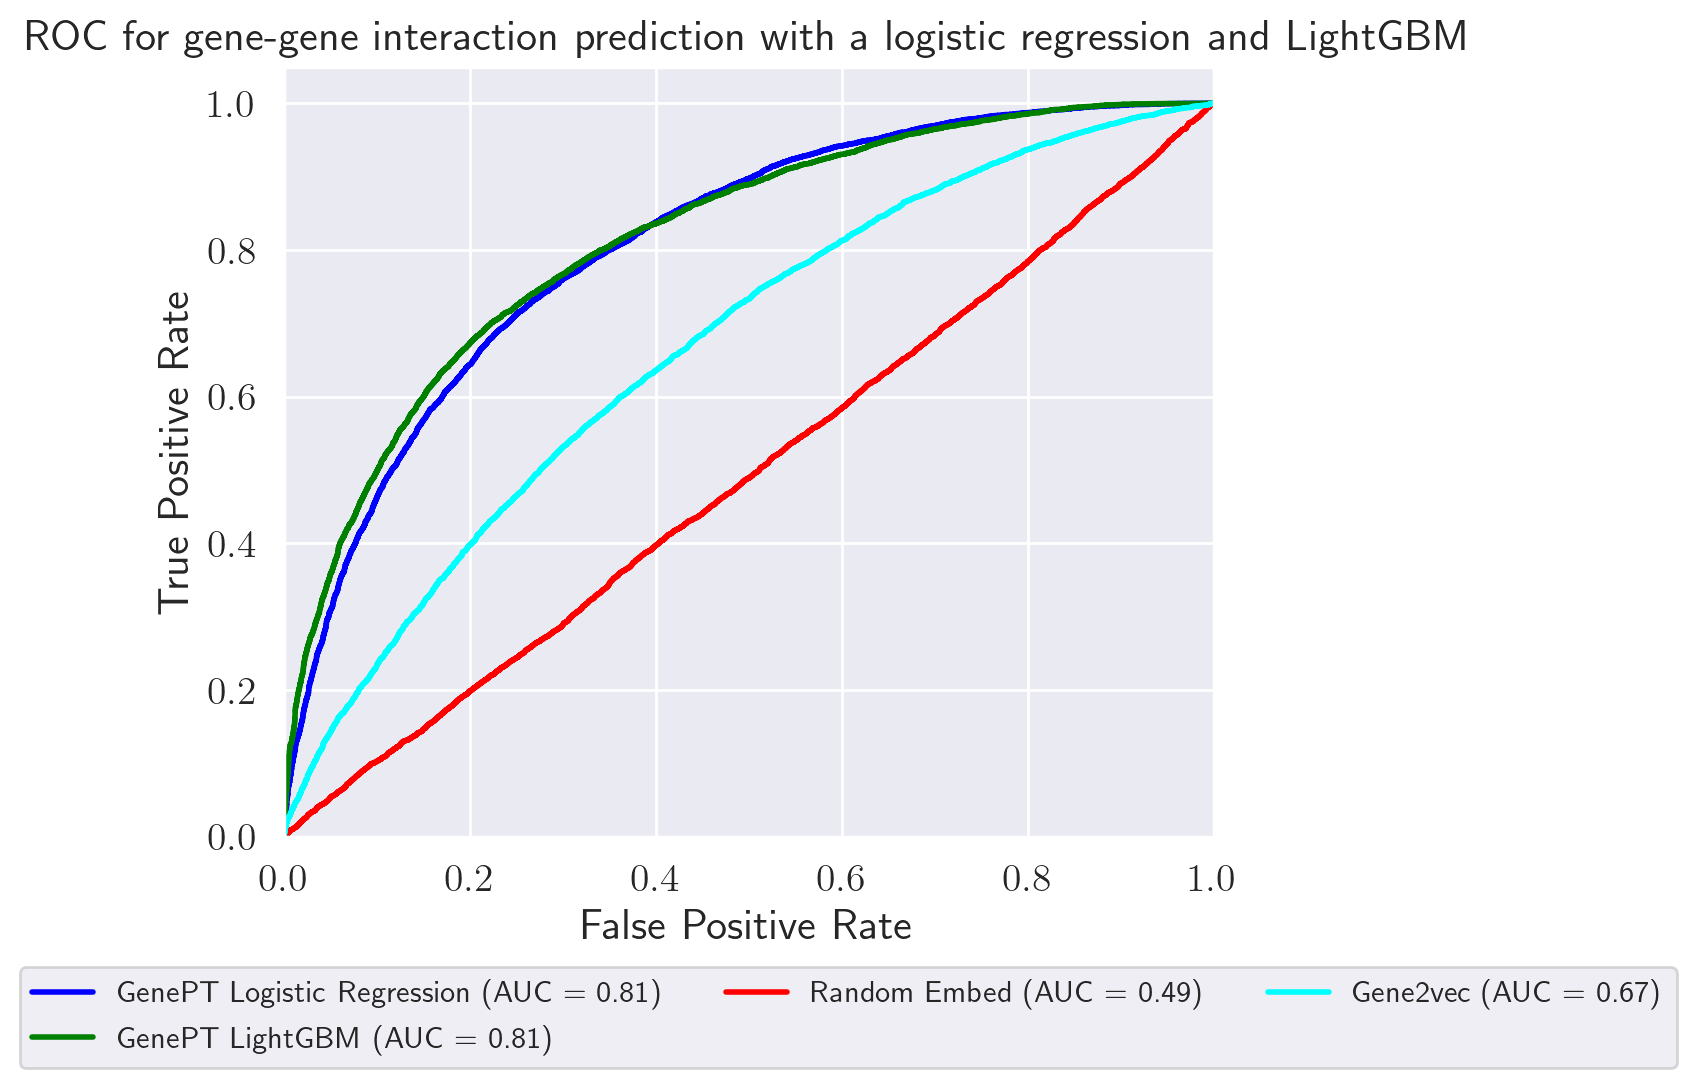

In [28]:
# Plot ROC curves
plt.figure()
plt.figure(figsize=(6,5))

plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, 
         label='GenePT Logistic Regression (AUC = %0.2f)' % rf_auc)
plt.plot(fpr_lgbm, tpr_lgbm, color='green', lw=2, 
         label='GenePT LightGBM (AUC = %0.2f)' % auc_lgbm)
plt.plot(fpr_random_rf, tpr_random_rf, color='red', lw=2, 
         label='Random Embed (AUC = %0.2f)' % auc_rf_random)
plt.plot(fpr_gene2vec_rf, tpr_gene2vec_rf, color='cyan', lw=2, 
         label='Gene2vec (AUC = %0.2f)' % auc_rf_gene2vec)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for gene-gene interaction prediction with a logistic regression and LightGBM')
plt.legend(loc='upper left',bbox_to_anchor=(-0.3, -0.15),fontsize=11,ncol=3)